Today we're going to look at the simplest models of neural networks that we showed in lecture - the perceptron and the multilayer perceptron. 

# Perceptron

The implementation of the perceptron algorithm is simple - the perceptron parameters are just one vector and the adaptation rule is also simple. We implement it as a class that has an interface inspired by the popular scikit-learn library, i.e. the parameters are set in the constructor and the class then has two methods - `fit(X, y)` and `predict(X)`.

We use matrix notation in the methods - we write the weighted sum as a scalar product. This, combined with the use of the `numpy` library, greatly simplifies the implementation and makes the algorithm faster.

In [1]:
import numpy as np

class Perceptron:
    
    def __init__(self, lr, max_iter=100):
        self.lr = lr
        self.max_iter = max_iter
        
    def fit(self, train_X, train_y):
        train_x = np.array(train_X)
        train_x = self._add_ones(train_x)
        self.w_ = np.zeros(train_x.shape[1])
        
        for _ in range(self.max_iter):
            for x,y in zip(train_x, train_y):
                y_hat = (np.sign(np.dot(x, self.w_.T)) + 1)/2 # we cannot use predict here, it would append another '1'
                self.w_ = self.w_ + self.lr*(y - y_hat)*x
        
    def predict(self, X):
        x = np.array(X)
        x = self._add_ones(x)
        return (np.sign(np.dot(x, self.w_.T)) + 1)/2 # sign -1 or 1 -> change to 0 or 1
    
    def _add_ones(self, x): # add a column of 1s instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

To test this, we generate some data. We will use simple data generators from the scikit-learn library to create data with two classes. Note the different results if the classes are separable and if they are not.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# simple method to visualize the decision boundary of the model, later we will also use it for one-hot encoding
def draw_boundary(model, X, y, one_hot=False):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if one_hot:
        Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.show()

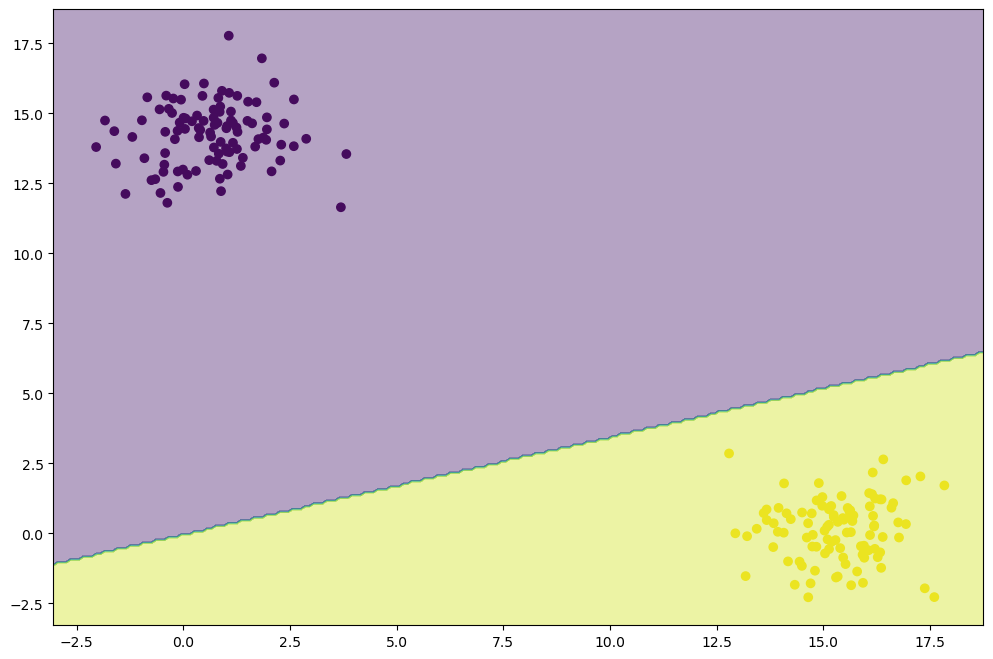

In [3]:
from sklearn import datasets

X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

perc = Perceptron(0.1, 1000)
perc.fit(X, y)
draw_boundary(perc, X, y)

# Multi-layered perceptron

The implementation of a multilayer neural network is similarly simple to that of a perceptron, it is just necessary to reiterate what the adaptation rules look like. We will use matrix notation again.

In [4]:
class MLP:
    
    def __init__(self, layer_sizes, alpha=0.1):
        self.layer_sizes = layer_sizes
        self.layers = []
        self.alpha = alpha
        
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            self.layers.append(np.random.normal(size=(p+1, n)))
        
    def predict(self, X):
        activations = np.array(X)
        try:
            for layer in self.layers:
                activations_1 = self._add_ones(activations) # pridame 1 pro bias
                activations = 1/(1+np.exp(np.dot(activations_1, layer)))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations
    
    def fit(self, X, y):
        pass
        # try to implement this yourselves
        
    def _add_ones(self, x): # add a column of ones instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

In [5]:
mlp = MLP([3,5,2])

mlp.predict(np.array([[1,2,3], [1,2,7]]))

array([[0.49462278, 0.60237791],
       [0.52986157, 0.57872605]])

# Brief introduction to tensorflow

Modern libraries such as `tensorflow` are used nowadays to implement neural networks. Today we will show how to use the so-called keras interface to create and train a simple feedforward network.

In [6]:
# prepare the data

x, y = datasets.make_blobs(n_samples=300, centers=3)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]

import tensorflow as tf

# set the network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ]
)

# set the optimization
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the network
model.fit(x_train, y_train, epochs=200, verbose=0)
# predict some of the instances
model.predict(x_test[:10])

1/1 [==============================] - 0s 84ms/step


array([[0.9101225 , 0.01298172, 0.0768958 ],
       [0.05539866, 0.12794267, 0.8166586 ],
       [0.9051576 , 0.01428051, 0.08056179],
       [0.07523347, 0.08392639, 0.8408401 ],
       [0.01731137, 0.82775253, 0.154936  ],
       [0.8693009 , 0.08539318, 0.04530583],
       [0.0182206 , 0.8168879 , 0.16489144],
       [0.05003313, 0.20838343, 0.7415834 ],
       [0.891828  , 0.01759386, 0.09057821],
       [0.05011005, 0.0880364 , 0.8618536 ]], dtype=float32)

455/455 [==============================] - 0s 769us/step


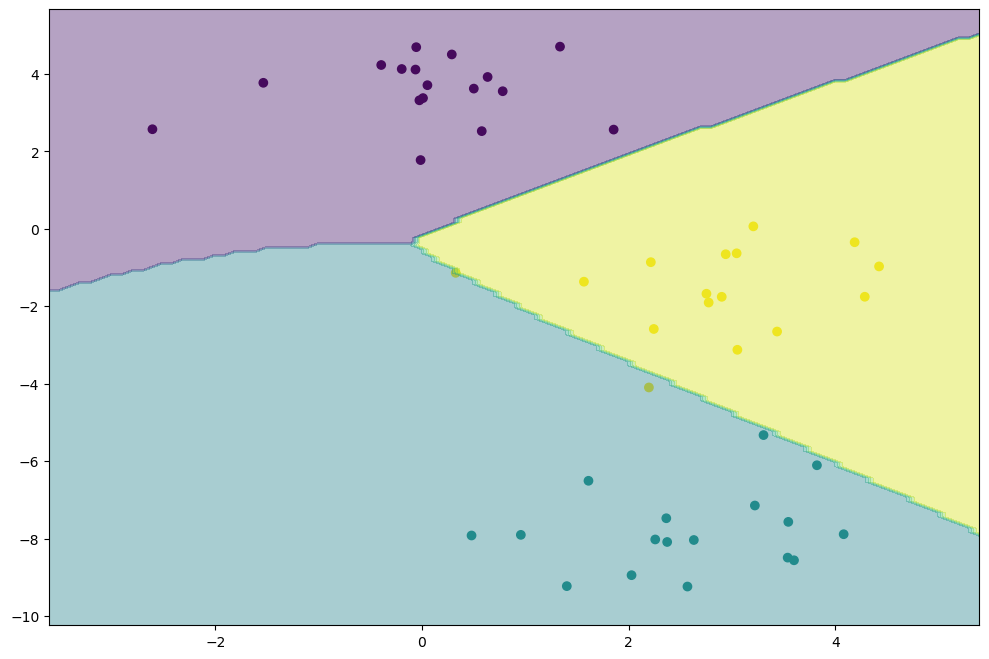

In [7]:
draw_boundary(model, x_test, y_test, one_hot=True)

In most cases, you'll probably use tensorflow at a similar level to above, i.e. you'll be creating models from existing modules. But let's quickly look a little deeper at how tensorflow works.

Tensorflow is really a library for symbolic computation. In it, we can define a computation (expression) that we will evaluate later. From a neural network point of view, it is important that tensorflow can also compute the gradient from this expression, and it also contains a number of optimizers.

There are three main types of "variables" in tensorflow - Placeholder is used for inputs to the expression (when we want to evaluate it later, we have to give them a value), Constant is used for constants, and Variable is used for variables that can possibly be trained. An example of creating a simple expression that computes a linear model of type $b + \sum_{i=1}^3 w_i x_i$ is below. Note that $x$ is a placeholder and doesn't get a value until later. In addition, we also compute the MSE based on $y$, so we have a ready-made model for linear regression that can learn to predict $y$ based on $x$.

The examples below use the old tensorflow v1 interface that had a number of low-level functions. Some of these were (re)moved in tensorflow 2. These are the functions starting with `tf.compat.v1`

In [8]:
import pprint
# create training data and print them
x_train = np.random.uniform(0, 1, size=(100, 3))
y_train = np.dot(x_train, np.array([2,3,1])) + 1
pprint.pprint(list(zip(x_train, y_train))[:10])

[(array([0.51194953, 0.43901121, 0.61152266]), 3.952455326242053),
 (array([0.99724695, 0.58953752, 0.3844921 ]), 5.147598562616574),
 (array([0.26927895, 0.92880602, 0.60726839]), 4.932244364148808),
 (array([0.79738075, 0.09222199, 0.05808843]), 2.9295158979345812),
 (array([0.72995046, 0.70966003, 0.5687689 ]), 5.15764989587571),
 (array([0.31482197, 0.83575668, 0.69048489]), 4.827398873742615),
 (array([0.4860042 , 0.02961892, 0.8262074 ]), 2.887072565576691),
 (array([0.60662815, 0.95071771, 0.76668624]), 5.832095651490695),
 (array([0.2720509 , 0.65917173, 0.47502419]), 3.9966411846453065),
 (array([0.74403833, 0.03162495, 0.29102562]), 2.8739771500712674)]


In [9]:
# remove the previous model
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# define the model inputs
# None in shape means that this dimension will be defined later - typically it is used for the training/testing data,
# where we do not know how many instance we will get, only one dimension can be None
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
y = tf.compat.v1.placeholder(tf.float32, shape=(None,))

# define the trainable variables, we need to specify initial values for them
w = tf.Variable(tf.compat.v1.random_uniform(shape=(3,)))
b = tf.Variable(tf.compat.v1.random_uniform(shape=(1,)))
# and we can use the variables to define the output of the model
z = tf.tensordot(x, w, 1) + b

# define the loss function
loss = tf.reduce_mean(tf.compat.v1.squared_difference(z, y))

# before we can evaluate the model, we must set the variables initializer
init = tf.compat.v1.global_variables_initializer()

# if we want to train the model, we need to set up the optimizer - it will use the loss function defined above

optim = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(loss)

# tensorflow can also compute gradients
grad = tf.gradients(loss, xs=[w,b])    

# all computations in tensorflow run in a Session
with tf.compat.v1.Session() as sess:
    # if we want to evaluate something, we use Session.run()
    sess.run(init)  # initialize the variables
    
    # we can print the values of the variables (we need to call run to compute the values)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    # we can specify the values of placeholders with feed-dict
    print('z:', sess.run(z, feed_dict={x: [[1,1,1]]}))
    
    print('loss:', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # tensorflow can compute the gradients
    wg,bg = sess.run(grad, feed_dict={x: x_train, y:y_train})
    print('wg:', wg)
    print('bg:', bg)
    # one call to optim runs one step of gradient descend
    for k in range(10):
        for i in range(100):
            sess.run(optim, feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # we can also print the values to check the result
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # we can also implement the optimization manually using the gradient descend algorithm
    print('='*50)
    
    sess.run(init)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # let us define the operations from the gradient descend algorithm, we need to define them outside of the loop,
    # otherwise they would be added to the computation loop mutliple times and slow the computation down considerably
    # NOT THIS: sess.run([w.assign_sub(0.1*wg), b.assign_sub(0.1*bg)], feed_dict={x: x_train, y:y_train})
    wg, bg = grad
    w_update=w.assign_sub(0.1*wg)
    b_update=b.assign_sub(0.1*bg)
    
    for k in range(10):
        for i in range(100):
            # session.run can evaluate mutliple expressions at the same time
            sess.run([w_update, b_update], feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    
    # let't print the values of the parameters again
    w_, b_ = sess.run([w,b])
    print('w:', w_)
    print('b:', b_)

w: [0.15043235 0.11718762 0.7883452 ]
b: [0.23332608]
z: [1.2892913]
loss: 11.502389
wg: [-3.5023985 -3.7684388 -3.3363786]
bg: [-6.46558]
epoch 100: loss  0.026067821
epoch 200: loss  0.0023999198
epoch 300: loss  0.00030313348
epoch 400: loss  4.328474e-05
epoch 500: loss  6.4031133e-06
epoch 600: loss  9.559593e-07
epoch 700: loss  1.429787e-07
epoch 800: loss  2.1407434e-08
epoch 900: loss  3.2205827e-09
epoch 1000: loss  4.8478155e-10
w: [1.9999579 2.9999654 0.999948 ]
b: [1.0000677]
w: [0.44386017 0.9871526  0.8225678 ]
b: [0.41447628]
epoch 100: loss  0.01416226
epoch 200: loss  0.0013645287
epoch 300: loss  0.0001765638
epoch 400: loss  2.5410396e-05
epoch 500: loss  3.7665625e-06
epoch 600: loss  5.6280385e-07
epoch 700: loss  8.423523e-08
epoch 800: loss  1.263688e-08
epoch 900: loss  1.9113562e-09
epoch 1000: loss  2.963364e-10
w: [1.9999675 2.9999719 0.9999601]
b: [1.000053]
